## Import Packages
Import common packages

In [19]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

Tell python where your local copy of *chmap* is located

In [2]:
import sys
sys.path.append("/Users/turtle/GitReps/CHMAP")

Import chmap functions

In [16]:
import chmap.utilities.datatypes.datatypes as psi_dtypes
import chmap.database.db_funs as db_funcs
import chmap.database.db_classes as db_class
import chmap.data.corrections.iit.IIT_pipeline_funcs as iit_funcs
import chmap.data.corrections.lbcc.LBCC_theoretic_funcs as lbcc_funcs
import chmap.utilities.plotting.psi_plotting as psi_plots

## Set parameters

In [6]:
####### ------ UPDATABLE PARAMETERS ------ #########
# TIME RANGE FOR LBC CORRECTION AND IIT HISTOGRAM CREATION
lbc_query_time_min = datetime.datetime(2011, 2, 1, 0, 0, 0)
lbc_query_time_max = datetime.datetime(2011, 2, 2, 0, 0, 0)

# TIME RANGE FOR FIT PARAMETER CALCULATION
calc_query_time_min = datetime.datetime(2011, 4, 1, 0, 0, 0)
calc_query_time_max = datetime.datetime(2011, 10, 1, 0, 0, 0)
weekday = 0  # start at 0 for Monday
number_of_days = 180  # days for moving average
# TIME WINDOWS FOR IMAGE INCLUSION
image_freq = 2      # number of hours between window centers
image_del = np.timedelta64(30, 'm') # one-half window width

# TIME RANGE FOR IIT CORRECTION AND IMAGE PLOTTING
iit_query_time_min = datetime.datetime(2011, 2, 1, 0, 0, 0)
iit_query_time_max = datetime.datetime(2011, 2, 7, 0, 0, 0)
plot = True  # true if you want to plot resulting images
n_images_plot = 1  # number of images to plot

# TIME RANGE FOR HISTOGRAM CREATION
hist_query_time_min = datetime.datetime(2011, 4, 1, 0, 0, 0)
hist_query_time_max = datetime.datetime(2011, 10, 1, 0, 0, 0)

# INSTRUMENTS
inst_list = ["AIA", "EUVI-A", "EUVI-B"]
ref_inst = "AIA"  # reference instrument to transform other instruments to
wavelengths = [193, 195]

# declare map and histogram-binning parameters
n_mu_bins = 18
n_intensity_bins = 200
R0 = 1.01     # Solar radii. What portion of the image to use?
log10 = True
lat_band = [-np.pi / 2.4, np.pi / 2.4]


## Set Database Paths
This example assumes that our example database and filesystem are located locally at '/Volumes/extdata2/CHMAP_DB_example'. The example database with filesystem can be downloaded [here](http://www.predsci.com/chmap/example_db/CHMAP_DB_example.zip) (~6GB).

In [10]:
# DATABASE FILE-SYSTEM PATHS
raw_data_dir = "/Volumes/extdata2/CHMAP_DB_example/raw_images"
hdf_data_dir = "/Volumes/extdata2/CHMAP_DB_example/processed_images"

# DATABASE CONNECTION
create = True  # set to False to disallow writes to the database
db_type = "sqlite"
sqlite_path = "/Volumes/extdata2/CHMAP_DB_example/chmap_example.db"

In [11]:
# connect to database
db_session = db_funcs.init_db_conn(db_type, db_class.Base, db_loc=sqlite_path)

Attempting to connect to SQLite DB server /Volumes/extdata2/CHMAP_DB_example/chmap_example.db
Connection successful



## Choose an image for demonstration

In [29]:
# query EUV images from Stereo-A
query_instrument = ["EUVI-A", ]
query_pd_all = db_funcs.query_euv_images(db_session=db_session, time_min=lbc_query_time_min,
                                         time_max=lbc_query_time_max, instrument=query_instrument,
                                         wavelength=wavelengths)
use_image = query_pd_all.loc[4]
print(use_image)

data_id                                                    30763
date_obs                                     2011-02-01 10:00:30
instrument                                                EUVI-A
wavelength                                                   195
distance                                             143867000.0
cr_lon                                                    288.31
cr_lat                                                  -4.39192
cr_rot                                                    2106.2
flag                                                           0
time_of_download                             2020-09-30 18:54:44
fname_raw           2011/02/01/sta_euvi_20110201T100030_195.fits
fname_hdf           2011/02/01/euvia_lvl2_20110201T100030_195.h5
Name: 4, dtype: object


## Apply limb correction

In [13]:
# apply limb correction to chosen image
original_los, lbcc_image, mu_indices, use_indices, theoretic_query = lbcc_funcs.apply_lbc_2(
    db_session, hdf_data_dir, use_image, n_intensity_bins=n_intensity_bins, R0=R0)

## Generate equatorial histogram

In [23]:
# calculate IIT histogram from limb-corrected image
temp_hist = psi_dtypes.LBCCImage.iit_hist(lbcc_image, lat_band, log10)

# query IIT method_id
meth_name = "IIT"
method_id = db_funcs.get_method_id(db_session, meth_name)

# create IIT histogram datatype
iit_hist = psi_dtypes.create_iit_hist(lbcc_image, method_id[1], lat_band, temp_hist) 

Add histogram to database

In [ ]:
# add IIT histogram and meta data to database
# db_funcs.add_hist(db_session, iit_hist)

## Calculate IIT coefficients
The images in the sample database do not cover a large enough span of time to generate stable IIT coefficients, and the sample database already contains these coefficients. So the following code works, but is commented-out.  The function calc_iit_coefficients() will calculate IIT coefficients at multiple times as defined by iit_query_time_min/max, weekday, number_of_days, image_freq, and image_del.  At each time, coefficients are calculated by temporally-averaging post-LBCC equatorial intensity histograms and fitting a linear transform to the reference instrument (AIA).  Coefficient values are then saved to the database.

In [ ]:
# Calculate IIT coefficients and store to database.
# iit_funcs.calc_iit_coefficients(db_session, inst_list, ref_inst, iit_query_time_min, iit_query_time_max,
#                                 weekday=weekday, number_of_days=number_of_days, image_freq=image_freq,
#                                 image_del=image_del, n_intensity_bins=n_intensity_bins,
#                                 lat_band=lat_band, create=create, wavelengths=wavelengths)

## Apply Correction

In [27]:
iit_image = iit_funcs.apply_iit_2(db_session, lbcc_image, use_indices, original_los, R0=R0)[0]

## Plot correction stages

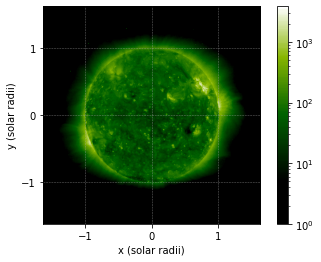

In [20]:
# Plot original (deconvolved) image
psi_plots.PlotImage(original_los)
plt.colorbar()
plt.show()

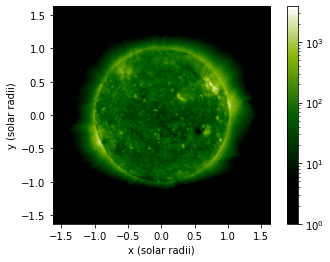

In [21]:
# Plot limb-corrected image
psi_plots.PlotCorrectedImage(lbcc_image.data, original_los)
plt.colorbar()
plt.show()

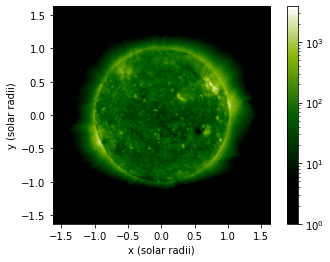

In [28]:
# Plot limb-corrected and inter-instrument-transformed image
psi_plots.PlotCorrectedImage(iit_image.data, original_los)
plt.colorbar()
plt.show()

### Wrap up

In [ ]:
# Close connection to database
db_session.close()